In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"] = "w"
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import classification_report,accuracy_score

from pyod.models.hbos import HBOS

# Synthetic data creation 

In [2]:
syntetic_dataset = {}
syntetic_dataset['num'] = [[-1.1], [0.2], [101.1], [0.3], [1], [0.5]]
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
rng = np.random.RandomState(42)
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
syntetic_dataset['norm'] = make_blobs(centers=[[0, 0], [0, 0]],
                                      cluster_std=0.5,
                                      **blobs_params)[0]
syntetic_dataset['2cluster'] = make_blobs(centers=[[2, 2], [-2, -2]],
                                          cluster_std=[0.5, 0.5],
                                          **blobs_params)[0]
syntetic_dataset['2moon'] = 4. * (make_moons(n_samples=n_samples,
                                             noise=.05,
                                             random_state=0)[0] 
                                  - np.array([0.5, 0.25]))

for dataset in syntetic_dataset.keys():
    # Add outliers
    if dataset == 'num':
      continue
    syntetic_dataset[dataset] = np.concatenate([syntetic_dataset[dataset],
                                                rng.uniform(low=-6, high=6, 
                                                            size=(n_outliers, 2))],
                                                axis=0)

In [3]:
print(syntetic_dataset['norm'].shape)
print(syntetic_dataset['2cluster'].shape)
print(syntetic_dataset['2moon'].shape)

(300, 2)
(300, 2)
(345, 2)


## Plotting the synthetic data

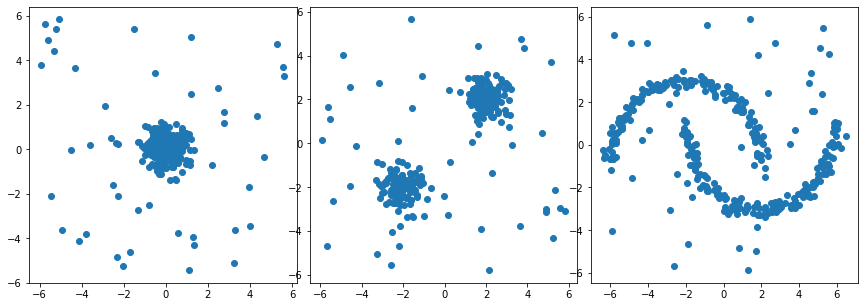

In [4]:
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=.02,
                    right=.98,
                    bottom=.001,
                    top=.96,
                    wspace=.05,
                    hspace=.01)
plt.subplot(1, 3,1)
plt.scatter(syntetic_dataset['norm'][:,0],syntetic_dataset['norm'][:,1])
plt.subplot(1, 3,2)
plt.scatter(syntetic_dataset['2cluster'][:,0],syntetic_dataset['2cluster'][:,1])
plt.subplot(1, 3,3)
plt.scatter(syntetic_dataset['2moon'][:,0],syntetic_dataset['2moon'][:,1])
plt.show()

# Anomaly detection using Gaussian model

In [5]:
def estimateGaussian(X):
    m = X.shape[0]
    #compute mean of X
    sum_ = np.sum(X,axis=0)
    mu = (sum_/m)
    # compute variance of X
    var = np.var(X,axis=0)
    print(mu, var)
    return mu,var

In [6]:
def multivariateGaussian(X, mu, sigma):
    k = len(mu)
    sigma=np.diag(sigma)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma) * X,axis=1))
    return p


## Anomaly detection using standard deviation 

In [7]:
X = syntetic_dataset['num']
mu, sigma = estimateGaussian(np.array(X))
StD = math.sqrt(sigma)
neg_thred = mu - 2 * StD
pos_thred = mu + 2 * StD

score = [1 if s > neg_thred and s < pos_thred else 0 for s in X]
print(score)
p = multivariateGaussian(X, mu, sigma)
print(p)

[17.] [1414.96666667]
[1, 1, 0, 1, 1, 1]
[0.00944627 0.00959894 0.00087119 0.00961031 0.00968835 0.00963288]


In [8]:
StD

37.616042676850874

## **Exercise** : Compute the means, standard deviations and probability  likelihood of each synthetic dataset

In [9]:
X = syntetic_dataset['norm']
mu, sigma = estimateGaussian(np.array(X))
p = multivariateGaussian(X, mu, sigma)
print(mu,sigma,p)

[-0.13161176  0.00641571] [2.17516743 2.13378821]
[-0.13161176  0.00641571] [2.17516743 2.13378821] [6.85204741e-02 7.37419371e-02 6.20645381e-02 7.29552641e-02
 4.75310715e-02 7.01222732e-02 7.16492170e-02 7.36041357e-02
 6.63243567e-02 5.72974409e-02 7.09935217e-02 6.05284127e-02
 6.97556727e-02 4.94782889e-02 6.53865717e-02 6.37881956e-02
 4.50405854e-02 6.02274273e-02 6.99938750e-02 5.81657776e-02
 6.53818311e-02 7.29765031e-02 6.16903876e-02 6.80929495e-02
 5.42027107e-02 7.33815967e-02 6.69423738e-02 6.47884013e-02
 6.27843592e-02 7.21173698e-02 4.52590706e-02 7.20219383e-02
 6.43722956e-02 6.51000386e-02 7.13226595e-02 6.61931556e-02
 7.00509489e-02 6.90601927e-02 6.73364326e-02 6.54119108e-02
 6.55742145e-02 5.86133487e-02 7.38570678e-02 5.12403283e-02
 6.90743068e-02 6.70713455e-02 6.35718680e-02 7.13257612e-02
 6.77221215e-02 6.31070215e-02 7.25808499e-02 6.48097802e-02
 7.14215417e-02 7.25387215e-02 5.78242108e-02 6.74811798e-02
 6.93567205e-02 5.66227113e-02 7.11087006e-02 

## Visualization of the anomaly in the dataset

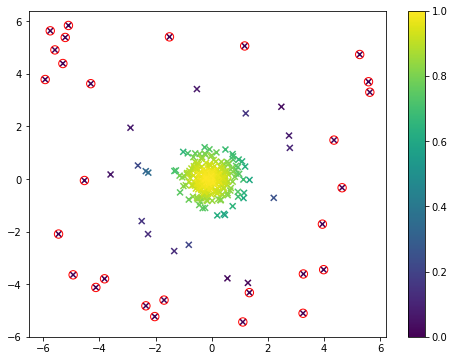

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
outliers = np.nonzero(p<0.001)[0]
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.colorbar();

### Exercise : Plot all the dataset

## Gaussian Mixture Models

In [11]:
n_components = 2
X = syntetic_dataset['2cluster']
gmm = GaussianMixture(n_components)
gmm.fit(X)
score = gmm.score_samples(X)

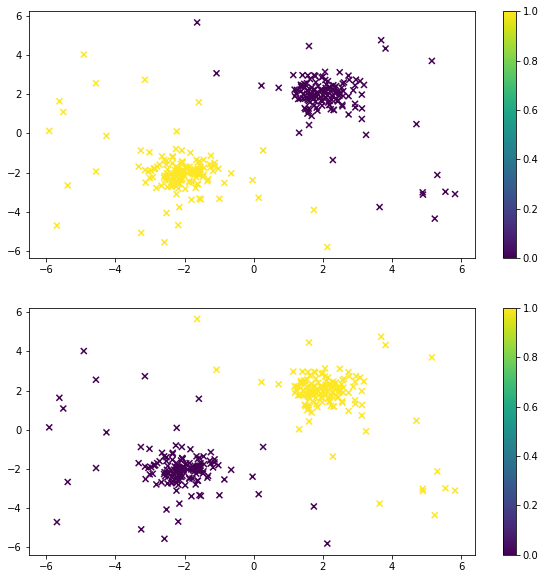

In [12]:
plt.figure(figsize=(10,10))
for i in range(n_components):
    plt.subplot(n_components,1,i+1)
    plt.scatter(X[:,0],X[:,1],c=gmm.predict_proba(X)[:,i],cmap='viridis',marker='x')
    plt.colorbar();

### Exercise : Plot the GMM on all the synthetic data

# Histogram-based outlier detection

Text(0.5, 1.0, 'Distribution of feature')

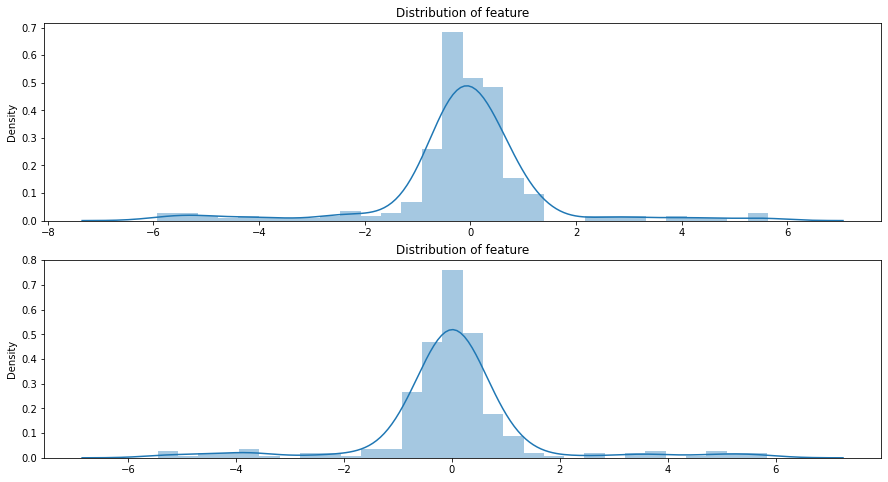

In [13]:
X = syntetic_dataset['norm']
plt.figure(figsize=(15,8))
gs = gridspec.GridSpec(2,1)
ax = plt.subplot(2,1,1)
sns.distplot(X[:,0],bins=30)
ax.set_xlabel('')
ax.set_title('Distribution of feature')

ax = plt.subplot(2,1,2)
sns.distplot(X[:,1],bins=30)
ax.set_xlabel('')
ax.set_title('Distribution of feature')

## Using HBOS from pyod

In [14]:
X = syntetic_dataset['norm']

outliers_fraction = 0.1
clf = HBOS(contamination=outliers_fraction)
clf.fit(X)
scores_pred = clf.decision_function(X) * -1
y_pred_norm = clf.predict(X)
n_inliers = len(y_pred_norm) - np.count_nonzero(y_pred_norm)
n_outliers = np.count_nonzero(y_pred_norm == 1)


## Exercise : Predict and visualize histogram base score

In [15]:
X = syntetic_dataset['2cluster']
clf.fit(X)
scores_pred = clf.decision_function(X) * -1
y_pred_clust = clf.predict(X)
n_inliers = len(y_pred_clust) - np.count_nonzero(y_pred_clust)
n_outliers = np.count_nonzero(y_pred_clust == 1)

In [16]:
X = syntetic_dataset['2moon']
clf.fit(X)
scores_pred = clf.decision_function(X) * -1
y_pred_moon = clf.predict(X)
n_inliers = len(y_pred_moon) - np.count_nonzero(y_pred_moon)
n_outliers = np.count_nonzero(y_pred_moon == 1)

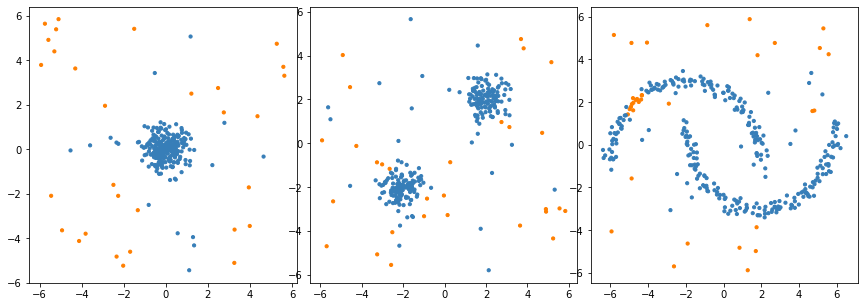

In [17]:
colors = np.array(['#377eb8', '#ff7f00'])
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=.02,
                    right=.98,
                    bottom=.001,
                    top=.96,
                    wspace=.05,
                    hspace=.01)
plt.subplot(1, 3,1)
plt.scatter(syntetic_dataset['norm'][:,0],syntetic_dataset['norm'][:,1], s=10, color=colors[(y_pred_norm + 1) // 2])
plt.subplot(1, 3,2)
plt.scatter(syntetic_dataset['2cluster'][:,0],syntetic_dataset['2cluster'][:,1], s=10, color=colors[(y_pred_clust + 1) // 2])
plt.subplot(1, 3,3)
plt.scatter(syntetic_dataset['2moon'][:,0],syntetic_dataset['2moon'][:,1], s=10, color=colors[(y_pred_moon + 1) // 2])
plt.show()

# K nearest neighbors

In [18]:
def k_nearest_neighbors(pt, pts, k):
    # Computes the Euclidean distance from pt to every point in pts
    distance_to_every_point = np.linalg.norm(pt - pts, axis=1)
    
    # Gets the sorted indices given the distances that we just found
    sorted_indices = np.argsort(distance_to_every_point)

    # Get the sorted points
    sorted_pts = pts[sorted_indices]
    
    # remove the first one as it is the same point as pt (because the distance is 0)
    sorted_pts = sorted_pts[1:]
    
    # Get me the first K of the sorted pts array
    return sorted_pts[:k] 

In [19]:
def KNN_anomaly_score(X, k, threshold):
    KNN_table = []

    # Gather the KNN for every point and store them in order in a list
    # A kd-tree would be preferred here, simply brute-forcing for simplicity
    # Storing this information in a table as we will need it for the other algorithms
    for i in range(X.shape[0]):
        KNN_table.append(k_nearest_neighbors(X[i], X, k))

    # Gather the kth nearest neighbor distance
    knn_distance = []
    for i in range(X.shape[0]):
        knn_distance.append(np.linalg.norm(X[i] - KNN_table[i][k-1]))

    # Gather the kth nearest neighbor distance
    knn_mean_distance = []
    for i in range(X.shape[0]):
        k_distances = np.linalg.norm(X[i] - np.array(KNN_table[i]), axis=1)
        knn_mean_distance.append(np.mean(k_distances))

    kth_score = np.array(knn_distance) > threshold
    kavg_score = np.array(knn_mean_distance) > threshold
    return kth_score, kavg_score

## Exercise Compute and visualize anomalies using Knn
**Try different K and threshold to see their effects**

In [20]:
X = syntetic_dataset['norm']
k = 10
threshold = 0.4
kth_score_norm, kavg_score_norm = KNN_anomaly_score(X, k, threshold)

In [21]:
X = syntetic_dataset['2cluster']
k = 10
threshold = 0.4
kth_score_clust, kavg_score_clust = KNN_anomaly_score(X, k, threshold)

In [22]:
X = syntetic_dataset['2moon']
k = 10
threshold = 0.4
kth_score_moon, kavg_score_moon = KNN_anomaly_score(X, k, threshold)

## kth NN score

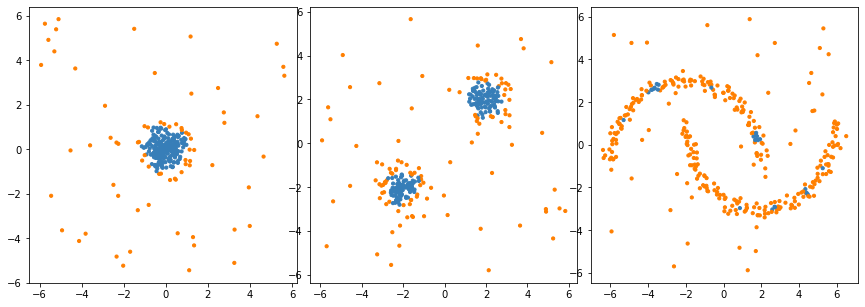

In [23]:
colors = np.array(['#377eb8', '#ff7f00'])
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=.02,
                    right=.98,
                    bottom=.001,
                    top=.96,
                    wspace=.05,
                    hspace=.01)
plt.subplot(1, 3,1)
plt.scatter(syntetic_dataset['norm'][:,0],syntetic_dataset['norm'][:,1], s=10, color=colors[(kth_score_norm + 1) // 2])
plt.subplot(1, 3,2)
plt.scatter(syntetic_dataset['2cluster'][:,0],syntetic_dataset['2cluster'][:,1], s=10, color=colors[(kth_score_clust + 1) // 2])
plt.subplot(1, 3,3)
plt.scatter(syntetic_dataset['2moon'][:,0],syntetic_dataset['2moon'][:,1], s=10, color=colors[(kth_score_moon + 1) // 2])
plt.show()

## k avg NN score

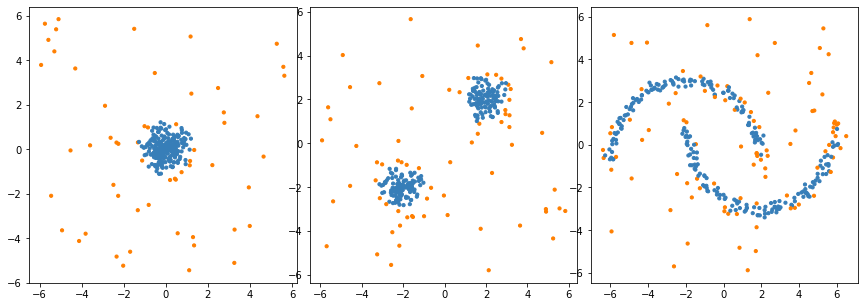

In [24]:
colors = np.array(['#377eb8', '#ff7f00'])
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=.02,
                    right=.98,
                    bottom=.001,
                    top=.96,
                    wspace=.05,
                    hspace=.01)
plt.subplot(1, 3,1)
plt.scatter(syntetic_dataset['norm'][:,0],syntetic_dataset['norm'][:,1], s=10, color=colors[(kavg_score_norm + 1) // 2])
plt.subplot(1, 3,2)
plt.scatter(syntetic_dataset['2cluster'][:,0],syntetic_dataset['2cluster'][:,1], s=10, color=colors[(kavg_score_clust + 1) // 2])
plt.subplot(1, 3,3)
plt.scatter(syntetic_dataset['2moon'][:,0],syntetic_dataset['2moon'][:,1], s=10, color=colors[(kavg_score_moon + 1) // 2])
plt.show()

# Local Outlier Factor

In [25]:
n_neighbors = 2
clf = LocalOutlierFactor(n_neighbors)
clf.fit_predict(syntetic_dataset['num'])

array([-1,  1, -1,  1, -1,  1])

In [26]:
clf.negative_outlier_factor_

array([  -4.95      ,   -0.91666667, -284.32499991,   -1.2       ,
         -2.2       ,   -0.91666667])

In [27]:
loc_y_pred_norm = clf.fit_predict(syntetic_dataset['norm'])
loc_y_pred_2cluster = clf.fit_predict(syntetic_dataset['2cluster'])
loc_y_pred_2moon = clf.fit_predict(syntetic_dataset['2moon'])

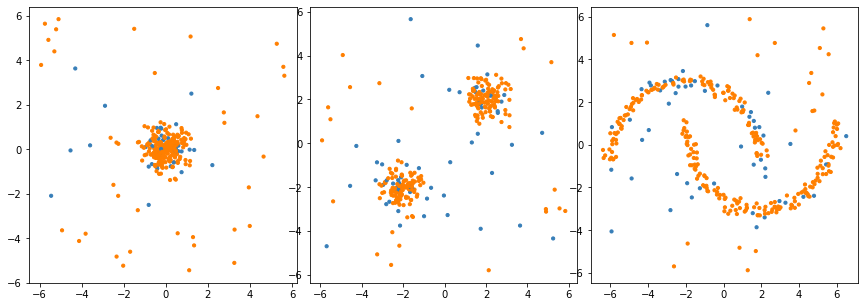

In [28]:
colors = np.array(['#377eb8', '#ff7f00'])
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=.02,
                    right=.98,
                    bottom=.001,
                    top=.96,
                    wspace=.05,
                    hspace=.01)
plt.subplot(1, 3,1)
plt.scatter(syntetic_dataset['norm'][:,0],syntetic_dataset['norm'][:,1], s=10, color=colors[(loc_y_pred_norm + 1) // 2])
plt.subplot(1, 3,2)
plt.scatter(syntetic_dataset['2cluster'][:,0],syntetic_dataset['2cluster'][:,1], s=10, color=colors[(loc_y_pred_2cluster + 1) // 2])
plt.subplot(1, 3,3)
plt.scatter(syntetic_dataset['2moon'][:,0],syntetic_dataset['2moon'][:,1], s=10, color=colors[(loc_y_pred_2moon + 1) // 2])
plt.show()

# Credit Card Fraud Detection
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation.

Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'.

## Loading the data

In [29]:
# Use the below code to read datasets from Google Drive

# from google.colab import drive
# drive.mount('/drive')

In [30]:
# Uncomment the below line to load data from Google drive
# creditcard_df = pd.read_csv('/drive/My Drive/anomaly_data/creditcard.csv')
creditcard_df = pd.read_csv('../datasets/creditcard.csv')
print(creditcard_df.columns)
creditcard_df.fillna(0, inplace=True)


Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


## Calculating the fraud frequency

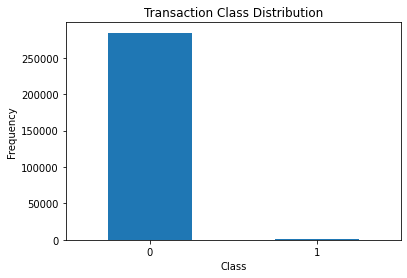

In [31]:
creditcard_Fraud = creditcard_df[creditcard_df['Class']==1]

creditcard_Normal = creditcard_df[creditcard_df['Class']==0]

outlier_fraction = len(creditcard_Fraud)/float(len(creditcard_Normal))

count_classes = pd.value_counts(creditcard_df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2))
plt.xlabel("Class")
plt.ylabel("Frequency");

In [32]:
creditcard_df.Amount.describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

## Data Visualization 

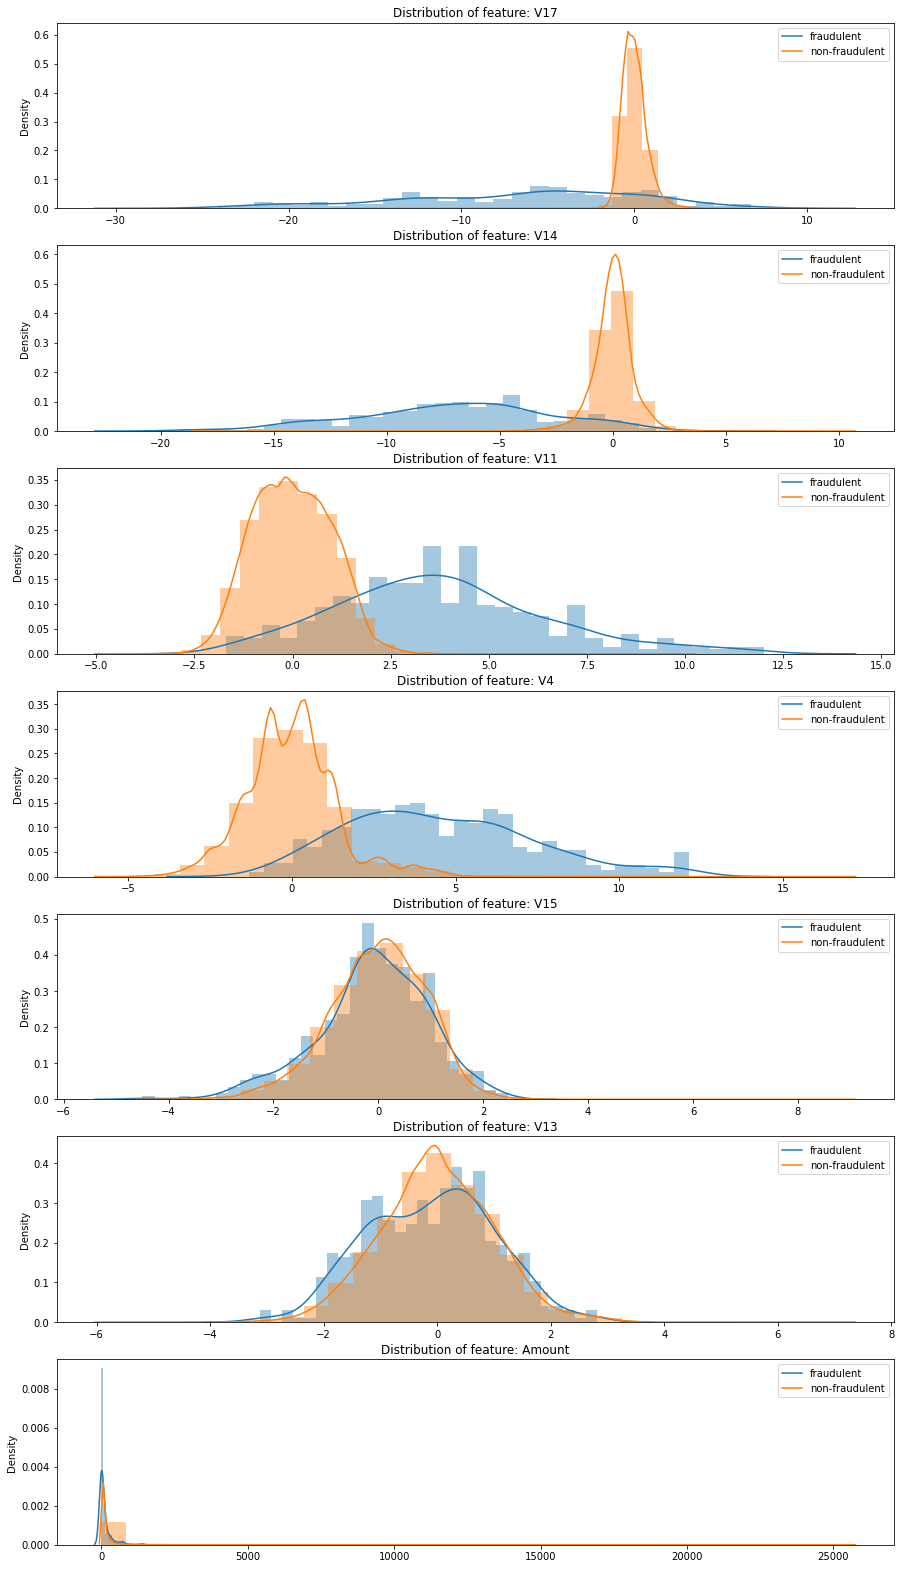

In [33]:
features=['V17','V14', 'V11', 'V4', 'V15', 'V13','Amount']
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(creditcard_df[feat][creditcard_df.Class==1], bins=30)
    sns.distplot(creditcard_df[feat][creditcard_df.Class==0], bins=30)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

## Training data creation 

In [34]:
# Filter the columns to remove data we do not want 
columns = [c for c in creditcard_df.columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
creditcard_X = creditcard_df[columns]
creditcard_Y = creditcard_df[target]
creditcard_X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(creditcard_X.shape)
print(creditcard_Y.shape)

(284807, 30)
(284807,)


## Local Outlier Factor on CCF

## Exercise : Detect anomalous transactions in credit card datasset using LOF

In [35]:
ccf_lof = LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                             leaf_size=30, metric='minkowski',
                             p=2, metric_params=None, contamination=outlier_fraction)

In [36]:
y_pred = ccf_lof.fit_predict(creditcard_X)
scores_prediction = ccf_lof.negative_outlier_factor_
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
n_errors = (y_pred != creditcard_Y).sum()

In [37]:
# Run Classification Metrics
print("LOF model Error: {}".format(n_errors))
print("Accuracy Score :")
print(accuracy_score(creditcard_Y,y_pred))
print("Classification Report :")
print(classification_report(creditcard_Y,y_pred))

LOF model Error: 935
Accuracy Score :
0.9967170750718908
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.05      0.05      0.05       492

    accuracy                           1.00    284807
   macro avg       0.52      0.52      0.52    284807
weighted avg       1.00      1.00      1.00    284807



# MNIST

In [38]:
#Uncomment the below code to load data from Google Drive
# mnist_df = pd.read_csv('/drive/My Drive/anomaly_data/mnist_train.csv', header=None)
mnist_df = pd.read_csv('../datasets/mnist_train.csv')
anomalous_classes =7
contamination= 0.01
mnist_df.describe()
data = mnist_df.values[:, 1:]
label = mnist_df.values[:, :1]

## Exercise : Anomaly detection in mnist

*   Treat one of the label (like 7) as anomaly 
*   Remove that label from the training dataset
*   Fit a model on the training data and try to detect the anomaly’s in the test data




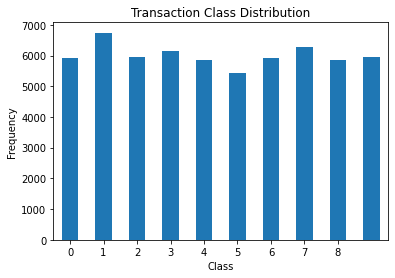

In [39]:
mnist_df.head()
mnist_Fraud = mnist_df[mnist_df['label']==7]
mnist_Normal = mnist_df[mnist_df['label']!=0]

mnist_outlier_fraction = len(creditcard_Fraud)/float(len(creditcard_Normal))

count_class_mnist = pd.value_counts(mnist_df['label'], sort = False)
count_class_mnist.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(9))
plt.xlabel("Class")
plt.ylabel("Frequency");

In [40]:

#Training data creation

# Filter the columns to remove data we do not want
columns = [c for c in mnist_df.columns if c not in ["label"]]
# Store the variable we are predicting
target = "label"
# Define a random state
state = np.random.RandomState(42)
mnist_X = mnist_df[columns]
mnist_Y = mnist_df[target]
mnist_X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(mnist_X.shape)
print(mnist_Y.shape)

(60000, 784)
(60000,)


In [41]:
ccf_lof = LocalOutlierFactor(n_neighbors=20, algorithm='auto',
                             leaf_size=30, metric='minkowski',
                             p=2, metric_params=None, contamination=outlier_fraction)

In [42]:
mnist_y_pred = ccf_lof.fit_predict(mnist_X)
mnist_scores_pred = ccf_lof.negative_outlier_factor_
mnist_y_pred[mnist_y_pred == 1] = 0
mnist_y_pred[mnist_y_pred == -1] = 1
n_error = (mnist_y_pred != mnist_Y).sum()

In [43]:
# Run Classification Metrics
print("LOF model Error: {}".format(n_error))
print("Accuracy Score :")
print(accuracy_score(mnist_Y,mnist_y_pred))
print("Classification Report :")
print(classification_report(mnist_Y,mnist_y_pred))

LOF model Error: 54059
Accuracy Score :
0.09901666666666667
Classification Report :
              precision    recall  f1-score   support

           0       0.10      1.00      0.18      5923
           1       0.17      0.00      0.01      6742
           2       0.00      0.00      0.00      5958
           3       0.00      0.00      0.00      6131
           4       0.00      0.00      0.00      5842
           5       0.00      0.00      0.00      5421
           6       0.00      0.00      0.00      5918
           7       0.00      0.00      0.00      6265
           8       0.00      0.00      0.00      5851
           9       0.00      0.00      0.00      5949

    accuracy                           0.10     60000
   macro avg       0.03      0.10      0.02     60000
weighted avg       0.03      0.10      0.02     60000

